### Authors:

Anderson Steckler, Sergeii P

Adapted from Sergeii P

### Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pybinding as pb
from pybinding.repository import graphene

In [2]:
import jax
import jax.numpy as jnp
from tqdm import tqdm

In [3]:
jax.config.update('jax_platform_name', 'cpu')

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5"
#os.environ["TF_FORCE_UNIFIED_MEMORY"]="1"

### Setting up graphene lattice and calculating LDOS at fixed position

In [4]:
# Basis Vectors
a1 = graphene.a * np.array([1, np.sqrt(3)])/2
a2 = graphene.a * np.array([-1, np.sqrt(3)])/2
a3 = graphene.a * np.array([1, 0])

at = graphene.a/np.sqrt(3) # Distance between A and B sublattices

# Here we model the defect as a gaussian potential
# We can specify whether its at sublattice points or inbetween
# Duterix 2019 Defect is on sublattice A

def pv(x, y):
  return -3*np.exp(-((1)*x**2+(1)*(y-at/2)**2)/(at)**2)

def defect():
  @pb.onsite_energy_modifier
  def potential(x, y):
    #return -3*np.exp(-(x**2+(y-at/2)**2)/(at)**2)
    return pv(x, y)

  return potential

# Create tightbinding model
model = pb.Model(graphene.monolayer(), pb.rectangle(50, 50), defect())

Plotting

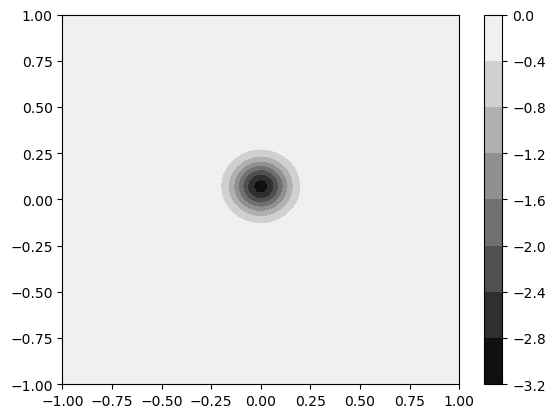

In [5]:
# Plotting defect potential
fig1, ax1 = plt.subplots()

x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)

xx, yy = np.meshgrid(x, y)
zz = pv(xx, yy)

h = ax1.contourf(xx, yy, zz, cmap='gray')
fig1.colorbar(h)

<a list of 0 AxesImage objects>
no


(-5.0, 5.0)

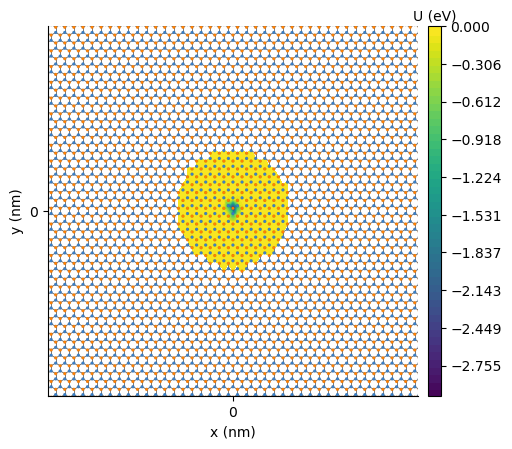

In [6]:
model.onsite_map.plot_contourf()
pb.pltutils.colorbar(label="U (eV)")
model.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

### LDOS with KPM

[0. 0.]
[-1.22975     2.12998948]


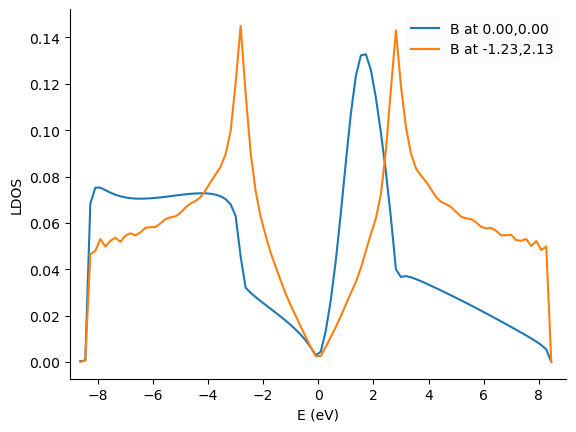

In [7]:
kpm = pb.kpm(model) # Kernal polynomial method. Instead of diagonalizing, explands everything in terms of Chebyshev polynomials

# Calculate LDOS close and far away
positions = [a1 * 0, a2 * 10]
sublattices = ['B', 'B'] # Which sub lattice we want to calculate for

for p, s in zip(positions, sublattices):
  print(p)
  ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 100), broadening=0.1, position=p, sublattice=s)
  ldos.plot(label=s + " at {pa:.2f},{pb:.2f}".format(pa=p[0], pb=p[1]))

pb.pltutils.legend()

### Discrete Spatial LDOS at fixed energy

In [8]:
size = 20 # half of lateral size
energies = np.array([0.2]) # eV

spatial_ldos = kpm.calc_spatial_ldos(np.linspace(-3, 3, 100),
                                     broadening=0.1, #eV
                                     shape=pb.rectangle(size*2))

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:03:22 / ETA: 0:00:00


(-20.0, 20.0)

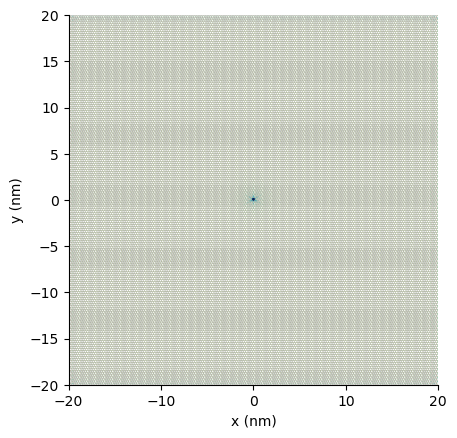

In [9]:
# Plotting
fig2, ax2 = plt.subplots()

smap = spatial_ldos.structure_map(energies[0])
smap.plot(site_radius=(0.02, 0.15))
ax2.set_xlim(-size, size)
ax2.set_ylim(-size, size)

In [9]:
import pickle

with open("smap_test.pkl", "wb") as fileo:
  pickle.dump(spatial_ldos, fileo, protocol=pickle.HIGHEST_PROTOCOL)

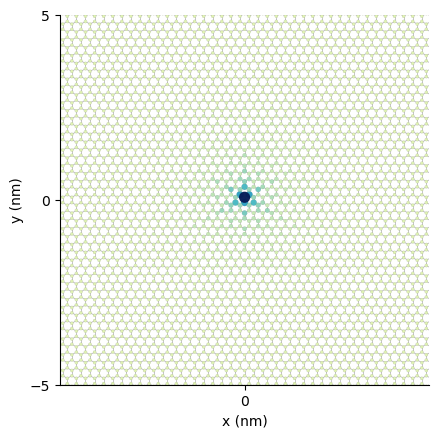

In [10]:
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)

fig2

### Continuous Spatial LDOS

In [11]:
@jax.jit
def spread(x, y, x0, y0, psi2):
    return psi2*jnp.exp(-((x-x0)**2+(y-y0)**2)/(at)**2)

In [12]:
# Source Grid (Convert everything to jax numpy)
(X, Y, Z) = smap.spatial_map.positions
psi2 = jnp.array(smap.data)

X = jnp.array(X)
Y = jnp.array(Y)

# Spatial Grid 1000
mesh_size = 1000
x, y = jnp.meshgrid(jnp.linspace(-size, size, mesh_size),
                   jnp.linspace(-size, size, mesh_size))
z = x*0

In [43]:
len(X)

61100

In [13]:
# Vectorize over new xy space
vecxy = jax.vmap(spread, in_axes=(0, 0, None, None, None))

# Vectorize over source space
vecq = jax.vmap(vecxy, in_axes=(None, None, 0, 0, 0))

In [15]:
# Batches :(
batchsize=100
totalsize = len(X) # X Y Psi should be same side since flattened meshgrid

bsizeS = 100
tsizeS = len(x.flatten())

results = []
for i in tqdm(range(0, totalsize, batchsize)):
    xbatch = X[i:i+batchsize]
    ybatch = Y[i:i+batchsize]
    psi2batch = psi2[i:i+batchsize]

    subresults = []

    for j in range(0, tsizeS, bsizeS):
        xsbatch = x.flatten()[j: j+bsizeS]
        ysbatch = y.flatten()[j: j+bsizeS]
        
        subresults.append(vecq(xsbatch, ysbatch, xbatch, ybatch, psi2batch))
    results.append(jnp.block(subresults))

# Concatenate
result = jnp.block(results)

  0%|          | 0/611 [00:00<?, ?it/s]

In [14]:
# Calculate contributions and sum over
result = vecq(x.flatten(), y.flatten(), X, Y, psi2)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 244400000000 bytes.

In [50]:
result_sum = jnp.sum(result, axis=0).reshape(mesh_size, mesh_size)
z_min, z_max = 0, jnp.abs(result_sum).max()

In [11]:
"""
(X, Y, Z) = smap.spatial_map.positions
psi2 = smap.data

mesh_size = 1000
x, y = np.meshgrid(np.linspace(-size, size, mesh_size),
                   np.linspace(-size, size, mesh_size))
z = x*0

# Interpolate by gaussian
# Every site impacts the points like a gaussian
# See Slater-Koster tightbinding for graphene band structure
for (X, Y, psi2) in tqdm(zip(X, Y, psi2)):
  z += psi2*np.exp(-((x-X)**2+(y-Y)**2)/(at)**2)

z_min, z_max = 0, np.abs(z).max()
"""

61100it [15:53, 64.07it/s]


In [25]:
### Saving data so I do not need to run again
import pickle

with open('smooth_psi2_2def_wider.pkl', 'wb') as file:
  pickle.dump(psi2, file)

(-5.0, 5.0)

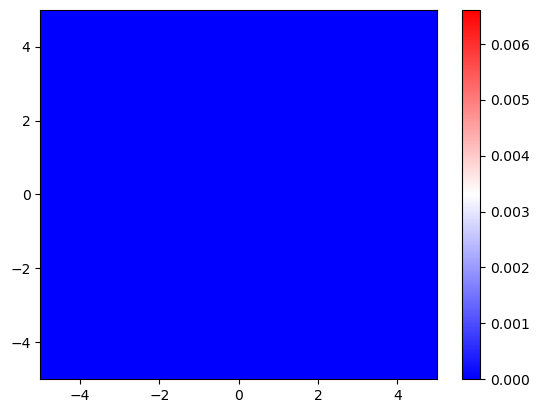

In [51]:
fig3, ax3 = plt.subplots()

c = ax3.pcolormesh(x, y, np.abs(result_sum), cmap='bwr', vmin=z_min, vmax=z_max)
ax3.axis([x.min(), x.max(), y.min(), y.max()])
fig3.colorbar(c, ax=ax3)
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)

In [27]:
# FFT
ftz = np.fft.fft2(z)
ftz = np.fft.fftshift(ftz) # Shifts zero component freq to center

# Log scale height
plz = np.log(np.abs(ftz ** 2))

fig4, ax4 = plt.subplots()
ax4.pcolormesh(plz, vmax=np.mean(plz)/100)

/tmp/ipykernel_5175/4002486943.py:6: RuntimeWarning: divide by zero encountered in log
  plz = np.log(np.abs(ftz ** 2))


Error in callback <function _draw_all_if_interactive at 0x7f7263781d00> (for post_execute), with arguments args (),kwargs {}:


ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 640x480 with 1 Axes>

In [14]:
# Try Han Filter
import skimage.draw

ModuleNotFoundError: No module named 'skimage'

In [ ]:
### Filtering Scattering Freqs

# Scattering Point
Kx = 2 * np.pi / graphene.a
Ky = (1/np.sqrt(3)) * Kx

K = 4*size/(3*graphene.a)

mask = np.zeros_like(plz)

x1 = K/2
y1 = K/2 * np.sqrt(3)

#x1 = 50
#y1 = 100

mask[skimage.draw.disk((500 + y1, 500 + x1), radius=10)] = 1
mask[skimage.draw.disk((500 - y1, 500 - x1), radius=10)] = 1

ftz_filtered = ftz * mask
plz_filtered = plz * mask

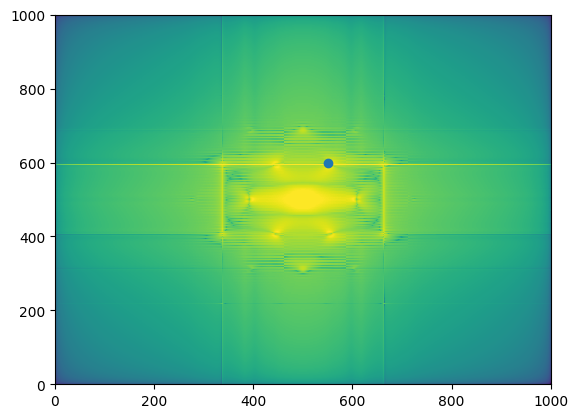

In [ ]:
figt, axt = plt.subplots()

axt.pcolormesh(plz, vmax=np.mean(plz)/100)
axt.scatter(550, 600)

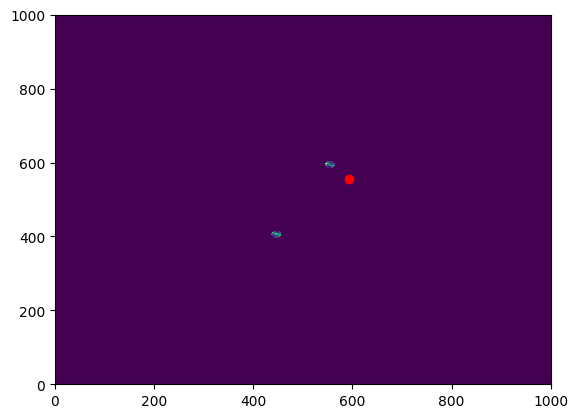

In [ ]:
fig5, ax5 = plt.subplots()

ax5.pcolormesh(np.abs(plz_filtered))
ax5.scatter(500 + y1, 500 + x1, color='red')

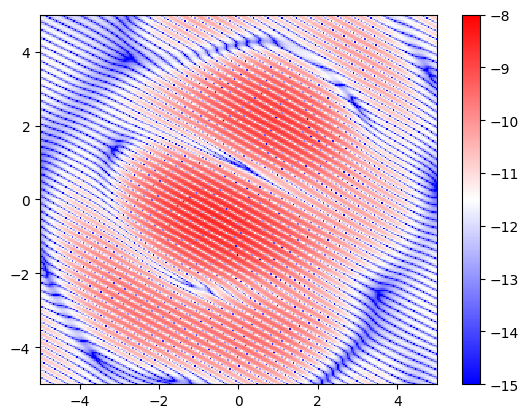

In [ ]:
z_filtered = np.fft.ifft2(ftz_filtered)

fig, ax = plt.subplots()

c = ax.pcolormesh(x,y,np.log(np.abs(z_filtered)),vmin=-15,vmax=-8, cmap='bwr')

fig.colorbar(c, ax=ax)
plt.xlim([-size/4,size/4])
plt.ylim([-size/4,size/4])
plt.show()

### Trying to import data from pickle